In [1]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [2]:
fn="cobi_state_data.csv"
df=pd.read_csv(fn)

In [3]:
rsspeedmax=10.
userPowermax=100.
ridingDurationmax=500.
ridingDistancemax=2000.
ascentmax=15.
caloriesmax=50.
heartratemax=150.
cadencemax=90.
averageSpeedmax=8.

df['rsspeed']=df['rsspeed']/rsspeedmax
df['userPower']=df['userPower']/userPowermax
df['ridingDuration']=df['ridingDuration']/ridingDurationmax
df['ridingDistance']=df['ridingDistance']/ridingDistancemax
df['ascent']=df['ascent']/ascentmax
df['calories']=df['calories']/caloriesmax
df['heartRate']=df['heartRate']/heartratemax
df['cadence']=df['cadence']/cadencemax
df['averageSpeed']=df['averageSpeed']/averageSpeedmax


In [4]:
cols=[col for col in df.columns ]
cols

['rsspeed',
 'userPower',
 'ridingDuration',
 'ridingDistance',
 'ascent',
 'calories',
 'heartRate',
 'cadence',
 'averageSpeed']

In [5]:
dftrain,dftest=train_test_split(df,test_size=0.15)
dftest['Class']=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
numinps= len(cols)
numinps

9

<p>Test/Train split for train and eval data.</p>

In [7]:
dftrain2,dfeval=train_test_split(dftrain,test_size=0.15)

<p>Building the autoencoder</p>

<p>So the Threshold is determined below and then put into the model as hardwired (not used to determine the threshold - no loops here) so that we can export the model at the same time.</p>

In [8]:
encodedim=14
hiddim=encodedim//2
learnrate=0.001
droprate=0.2
thresh=0.2 #picked as just above max value to detect anything outside the norm
threshold=tf.constant(thresh)
inputs=tf.placeholder(tf.float32, shape=(None,numinps),name="inputs")
#mode=tf.placeholder(tf.string, name="mode")

dense0 = tf.layers.dense(inputs=inputs, units=encodedim, activation=tf.nn.tanh)
dropout0 = tf.layers.dropout(inputs=dense0, rate=droprate)

dense1 = tf.layers.dense(inputs=dropout0, units=hiddim, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=droprate)

dense2 = tf.layers.dense(inputs=dropout1, units=hiddim, activation=tf.nn.tanh)
dropout2 = tf.layers.dropout(inputs=dense2, rate=droprate)

dense3 = tf.layers.dense(inputs=dropout2, units=numinps, activation=tf.nn.relu)
dropout3 = tf.layers.dropout(inputs=dense3, rate=droprate)

loss=tf.losses.mean_squared_error(labels=inputs,predictions=dropout3)
Yout=tf.cast(tf.math.greater(loss,threshold), tf.int32)
trainstep=tf.train.AdamOptimizer(learning_rate=learnrate).minimize(loss)


<p>Training Autoencoder and then exporting saved_model format.</p>

In [9]:
init = tf.global_variables_initializer()
batchsize=100
#xbatch=dftrain2.loc[:,cols].head(10).values
evalbatch=dfeval[cols]
numepochs=4

treerr=[]
everr=[]
modeldir="m_{:05d}".format(np.random.randint(100000))

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(numepochs):
        for i in range(dftrain2.shape[0]//batchsize):
            xbatch=dftrain2.iloc[i*batchsize:(i+1)*batchsize][cols]
            _,ltr=sess.run([trainstep,loss],feed_dict={inputs:xbatch})
            print("train: ",epoch,i,ltr)
            if i%20==0:
                l=sess.run([loss],feed_dict={inputs:evalbatch})
                print("evalu: ",epoch,i,l)
                treerr.append(ltr)
                everr.append(l)
     
    print("Running Test data...")
    out=[]
    for i in range(dftest.shape[0]):
        testbatch=np.array([dftest.iloc[i][cols].values])
        l=sess.run([loss,Yout],feed_dict={inputs:testbatch})
        out.append([dftest.iloc[i]['Class'],l[0]])
    tf.saved_model.simple_save(sess,modeldir, inputs=
                           {
                               "inputs":inputs#,'labels':labels,"learnrate":learnrate,"droprate":droprate,"mode":mode
                           },
                           outputs={"Yout":Yout}#,"batchloss":batchloss}
                          )

train:  0 0 0.28415745
evalu:  0 0 [0.26221836]
train:  0 1 0.2538927
train:  0 2 0.24496499
train:  0 3 0.25430876
train:  0 4 0.23816213
train:  0 5 0.24716203
train:  0 6 0.23803094
train:  0 7 0.23084171
train:  0 8 0.22942352
train:  0 9 0.23681481
train:  0 10 0.2153223
train:  0 11 0.2252487
train:  0 12 0.21585816
train:  0 13 0.22397712
train:  0 14 0.20839891
train:  0 15 0.21995819
train:  0 16 0.21143016
train:  0 17 0.21330862
train:  0 18 0.2128655
train:  0 19 0.21806867
train:  0 20 0.21082042
evalu:  0 20 [0.20626444]
train:  0 21 0.20520078
train:  0 22 0.20046498
train:  0 23 0.18976857
train:  0 24 0.19944838
train:  0 25 0.1918441
train:  0 26 0.19970296
train:  0 27 0.19915324
train:  0 28 0.2016513
train:  0 29 0.1976281
train:  0 30 0.18666369
train:  0 31 0.18188588
train:  0 32 0.18492953
train:  0 33 0.18744393
train:  0 34 0.18916576
train:  0 35 0.17864166
train:  0 36 0.17437503
train:  0 37 0.1777041
train:  0 38 0.1691256
train:  0 39 0.16708131
train:  

train:  2 114 0.087539725
train:  2 115 0.0946579
train:  2 116 0.09481533
train:  2 117 0.08830567
train:  2 118 0.08959347
train:  2 119 0.09027308
train:  2 120 0.081570305
evalu:  2 120 [0.0891635]
train:  2 121 0.09034017
train:  2 122 0.09150728
train:  2 123 0.09428333
train:  2 124 0.091353565
train:  2 125 0.0855011
train:  2 126 0.090693444
train:  2 127 0.08847911
train:  2 128 0.09101873
train:  2 129 0.09322715
train:  2 130 0.08589445
train:  2 131 0.08638716
train:  2 132 0.091145836
train:  2 133 0.090547845
train:  2 134 0.09087426
train:  2 135 0.0910946
train:  2 136 0.08899118
train:  2 137 0.09109343
train:  2 138 0.08782264
train:  2 139 0.08624077
train:  2 140 0.08618146
evalu:  2 140 [0.08893228]
train:  2 141 0.09178348
train:  2 142 0.0834552
train:  2 143 0.091796495
train:  2 144 0.087336935
train:  2 145 0.085897796
train:  2 146 0.08961163
train:  2 147 0.08555917
train:  2 148 0.09023733
train:  2 149 0.088879436
train:  2 150 0.091844976
train:  2 151 0

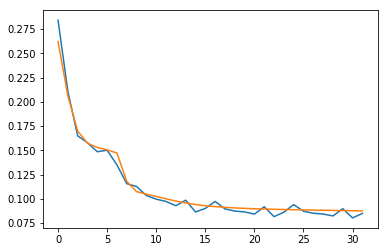

In [10]:
plt.plot(treerr)
plt.plot(everr)

In [11]:
out=np.array(out)
dfout=pd.DataFrame(data={"label":out[:,0],"err":out[:,1]})
dfout.describe()

,label,err
count,3288.0,3288.000000
mean,0.0,0.087218
std,0.0,0.029828
min,0.0,0.000725
25%,0.0,0.078680
50%,0.0,0.093318
75%,0.0,0.104880
max,0.0,0.198570


In [12]:
dfout.describe().loc['mean','err']+dfout.describe().loc['std','err']

0.11704557369297244

In [13]:
thresh2=dfout.describe().loc['mean','err']+dfout.describe().loc['std','err']
print("thresh2 of err = mean+std = ",thresh2)
dfout['pred2']=0
dfout.loc[dfout['err']>thresh2,'pred2']=1
dfout.pred2.sum()/df.shape[0]

thresh2 of err = mean+std =  0.11704557369297244


0.012092174309833448

In [18]:
#Defining Prediction from loss
print(thresh)
dfout['pred']=0
dfout.loc[dfout['err']>thresh,'pred']=1

0.2


In [20]:
dfout.describe()

,label,err,pred2,pred
count,3288.0,3288.000000,3288.000000,3288.0
mean,0.0,0.087218,0.080596,0.0
std,0.0,0.029828,0.272255,0.0
min,0.0,0.000725,0.000000,0.0
25%,0.0,0.078680,0.000000,0.0
50%,0.0,0.093318,0.000000,0.0
75%,0.0,0.104880,0.000000,0.0
max,0.0,0.198570,1.000000,0.0
